### Fine-tuning
In this notebook we focus on fine-tuning Lag-Llama on all the sensor data 1 from FOO1 dataset

#### Loading lib and datasets

In [73]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.dates as mdates
from itertools import islice
import torch
from gluonts.dataset.repository import get_dataset, dataset_names
from gluonts.dataset.util import to_pandas
from gluonts.dataset.common import ListDataset
from tqdm.autonotebook import tqdm
from gluonts.evaluation import make_evaluation_predictions, Evaluator
from gluonts.dataset.pandas import PandasDataset
from lag_llama.gluon.estimator import LagLlamaEstimator

In [3]:
df = pd.read_csv('/Users/junbo/studium/ma/CMAPSS Data/train_FD001.txt', index_col=0, sep=" ", header=None)
column_indices = np.arange(df.shape[1]-1).tolist()

index_columns_names =  ["cycle"]
op_settings_columns = ["op_setting_"+str(i) for i in range(1,4)]
sensor_columns =["sensor_"+str(i) for i in range(1,22)]
new_names = index_columns_names + op_settings_columns + sensor_columns

old_names = df.columns[column_indices]
df.rename(columns=dict(zip(old_names, new_names)), inplace=True)
df.index.names = ['engine']
df.drop([26, 27], axis=1, inplace=True)
df_sensor_14 = df[['cycle', 'sensor_14']]
df_sensor_14 = df_sensor_14.reset_index()

In [42]:
pivot_df = df_sensor_14.pivot(index='cycle', columns='engine', values='sensor_14')

# pivot_df = pivot_df.dropna() # truncate, only deal with the first 128 timestamps -- starting from 129th timestamp failure occured for one trajectory
pivot_df.index.name = 'timestamps'
pivot_df.index = pd.to_datetime(pivot_df.index, origin='1970-01-01', unit='h')
pivot_df

engine,1,2,3,4,5,6,7,8,9,10,...,91,92,93,94,95,96,97,98,99,100
timestamps,,,,,,,,,,,,,,,,,,,,,
1970-01-01 01:00:00,8138.62,8137.72,8138.40,8131.50,8152.22,8116.86,8141.69,8123.47,8149.16,8137.61,...,8134.25,8136.55,8139.06,8120.76,8153.89,8133.36,8130.81,8150.69,8131.23,8146.76
1970-01-01 02:00:00,8131.49,8131.09,8137.38,8129.53,8153.04,8126.01,8148.24,8120.18,8148.23,8142.57,...,8131.08,8135.54,8141.41,8126.19,8151.85,8136.21,8131.43,8147.03,8132.70,8143.56
1970-01-01 03:00:00,8133.23,8140.58,8137.20,8131.24,8148.42,8125.49,8148.83,8122.29,8140.94,8136.85,...,8134.12,8137.39,8140.79,8130.38,8148.79,8134.72,8129.52,8149.19,8132.44,8146.62
1970-01-01 04:00:00,8133.83,8140.44,8139.35,8132.90,8148.81,8117.06,8150.30,8123.80,8145.41,8136.62,...,8127.29,8135.96,8144.72,8126.63,8148.08,8134.52,8131.14,8156.01,8133.19,8146.60
1970-01-01 05:00:00,8133.80,8136.67,8135.99,8126.94,8147.69,8124.10,8149.40,8118.15,8145.92,8138.95,...,8132.13,8138.76,8144.23,8129.45,8144.88,8135.34,8130.03,8148.47,8132.30,8141.82
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1970-01-15 22:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1970-01-15 23:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1970-01-16 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [43]:
# shift and deal with NaN

first_valid_values = pivot_df.apply(lambda col: col.dropna().iloc[0])
for i in range(1, pivot_df.shape[1] + 1):
    pivot_df[i] = pivot_df[i].shift(periods=pivot_df[i].isna().sum(), fill_value=first_valid_values[i])
pivot_df

engine,1,2,3,4,5,6,7,8,9,10,...,91,92,93,94,95,96,97,98,99,100
timestamps,,,,,,,,,,,,,,,,,,,,,
1970-01-01 01:00:00,8138.62,8137.72,8138.40,8131.50,8152.22,8116.86,8141.69,8123.47,8149.16,8137.61,...,8134.25,8136.55,8139.06,8120.76,8153.89,8133.36,8130.81,8150.69,8131.23,8146.76
1970-01-01 02:00:00,8138.62,8137.72,8138.40,8131.50,8152.22,8116.86,8141.69,8123.47,8149.16,8137.61,...,8134.25,8136.55,8139.06,8120.76,8153.89,8133.36,8130.81,8150.69,8131.23,8146.76
1970-01-01 03:00:00,8138.62,8137.72,8138.40,8131.50,8152.22,8116.86,8141.69,8123.47,8149.16,8137.61,...,8134.25,8136.55,8139.06,8120.76,8153.89,8133.36,8130.81,8150.69,8131.23,8146.76
1970-01-01 04:00:00,8138.62,8137.72,8138.40,8131.50,8152.22,8116.86,8141.69,8123.47,8149.16,8137.61,...,8134.25,8136.55,8139.06,8120.76,8153.89,8133.36,8130.81,8150.69,8131.23,8146.76
1970-01-01 05:00:00,8138.62,8137.72,8138.40,8131.50,8152.22,8116.86,8141.69,8123.47,8149.16,8137.61,...,8134.25,8136.55,8139.06,8120.76,8153.89,8133.36,8130.81,8150.69,8131.23,8146.76
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1970-01-15 22:00:00,8117.69,8174.85,8238.86,8246.77,8203.89,8110.10,8146.81,8120.84,8266.83,8173.14,...,8119.61,8194.88,8138.51,8210.36,8179.43,8142.08,8255.95,8130.96,8123.55,8137.60
1970-01-15 23:00:00,8117.51,8166.83,8251.82,8241.99,8208.49,8110.79,8139.94,8117.88,8271.39,8177.31,...,8120.68,8201.61,8133.67,8208.35,8189.10,8140.98,8258.58,8136.99,8130.99,8136.50
1970-01-16 00:00:00,8112.58,8164.83,8249.86,8253.53,8206.86,8108.26,8149.60,8126.20,8272.83,8181.11,...,8120.11,8202.93,8143.45,8212.30,8187.88,8145.65,8257.38,8133.76,8126.90,8141.05


<Axes: xlabel='timestamps'>

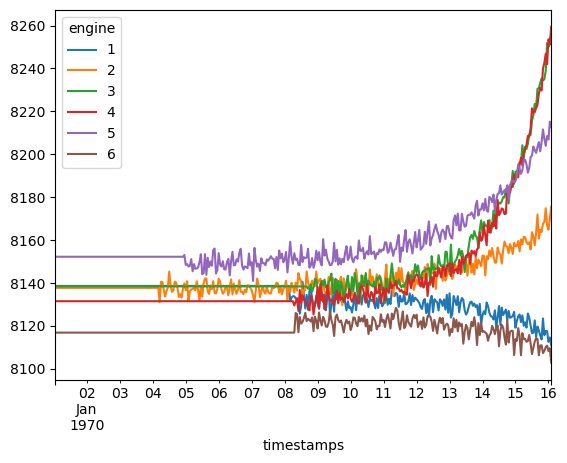

In [44]:
# quick vis
pivot_df[[1,2,3,4,5,6]].plot()

In [45]:
# convert df to training and testing datasets
prediction_length = 24

train_data = [{"start": pivot_df.index[0], "target": pivot_df[i].values[:-prediction_length]} for i in pivot_df.columns] # (128 - 24) by 100
test_data = [{"start": pivot_df.index[0], "target": pivot_df[i].values} for i in pivot_df.columns] # 128 by 100

train_ds = ListDataset(data_iter=train_data, freq='1H') # training dataset
test_ds = ListDataset(data_iter=test_data, freq='1H') # testing dataset

In [68]:
train_ds

[{'start': Period('1970-01-01 01:00', 'H'),
  'target': array([8138.62, 8138.62, 8138.62, 8138.62, 8138.62, 8138.62, 8138.62,
         8138.62, 8138.62, 8138.62, 8138.62, 8138.62, 8138.62, 8138.62,
         8138.62, 8138.62, 8138.62, 8138.62, 8138.62, 8138.62, 8138.62,
         8138.62, 8138.62, 8138.62, 8138.62, 8138.62, 8138.62, 8138.62,
         8138.62, 8138.62, 8138.62, 8138.62, 8138.62, 8138.62, 8138.62,
         8138.62, 8138.62, 8138.62, 8138.62, 8138.62, 8138.62, 8138.62,
         8138.62, 8138.62, 8138.62, 8138.62, 8138.62, 8138.62, 8138.62,
         8138.62, 8138.62, 8138.62, 8138.62, 8138.62, 8138.62, 8138.62,
         8138.62, 8138.62, 8138.62, 8138.62, 8138.62, 8138.62, 8138.62,
         8138.62, 8138.62, 8138.62, 8138.62, 8138.62, 8138.62, 8138.62,
         8138.62, 8138.62, 8138.62, 8138.62, 8138.62, 8138.62, 8138.62,
         8138.62, 8138.62, 8138.62, 8138.62, 8138.62, 8138.62, 8138.62,
         8138.62, 8138.62, 8138.62, 8138.62, 8138.62, 8138.62, 8138.62,
         8

#### loading the ckpt and building LagLlamaEstimator as the estimator

In [66]:
prediction_length = 24 # default
num_samples = 10 # default - for probability forecasting
context_length = 8
device = "mps"

ckpt = torch.load("lag-llama.ckpt", map_location=torch.device(device))

estimator_args = ckpt["hyper_parameters"]["model_kwargs"]

estimator = LagLlamaEstimator(
        ckpt_path="lag-llama.ckpt",
        prediction_length=prediction_length,
        context_length=context_length,

        # distr_output="neg_bin",
        # scaling="mean",
        nonnegative_pred_samples=True,
        aug_prob=0,
        lr=10e-4, # training params

        # estimator args
        input_size=estimator_args["input_size"],
        n_layer=estimator_args["n_layer"],
        n_embd_per_head=estimator_args["n_embd_per_head"],
        n_head=estimator_args["n_head"],
        time_feat=estimator_args["time_feat"],

        rope_scaling={
            "type": "linear",
            "factor": max(1.0, (context_length + prediction_length) / estimator_args["context_length"]),
        }, 

        batch_size=64,
        num_parallel_samples=num_samples,
        trainer_kwargs = {"max_epochs": 50,}, # <- lightning trainer arguments
    )

In [53]:
predictor = estimator.train(train_ds, cache_data=True, shuffle_buffer_length=1000)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/junbo/miniconda3/envs/lag_llama/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name          | Type               | Params
-----------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M 
1 | augmentations | ApplyAugmentations | 0     
-----------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)


Epoch 0: |          | 50/? [00:34<00:00,  1.45it/s, v_num=13]

Epoch 0, global step 50: 'train_loss' reached 9.27797 (best 9.27797), saving model to '/Users/junbo/studium/ma/code/lag_llama_model/lightning_logs/version_13/checkpoints/epoch=0-step=50.ckpt' as top 1


Epoch 1: |          | 50/? [00:32<00:00,  1.53it/s, v_num=13]

Epoch 1, global step 100: 'train_loss' reached 7.96147 (best 7.96147), saving model to '/Users/junbo/studium/ma/code/lag_llama_model/lightning_logs/version_13/checkpoints/epoch=1-step=100.ckpt' as top 1


Epoch 2: |          | 50/? [00:32<00:00,  1.53it/s, v_num=13]

Epoch 2, global step 150: 'train_loss' reached 7.80056 (best 7.80056), saving model to '/Users/junbo/studium/ma/code/lag_llama_model/lightning_logs/version_13/checkpoints/epoch=2-step=150.ckpt' as top 1


Epoch 3: |          | 50/? [00:32<00:00,  1.52it/s, v_num=13]

Epoch 3, global step 200: 'train_loss' reached 6.85388 (best 6.85388), saving model to '/Users/junbo/studium/ma/code/lag_llama_model/lightning_logs/version_13/checkpoints/epoch=3-step=200.ckpt' as top 1


Epoch 4: |          | 50/? [00:36<00:00,  1.38it/s, v_num=13]

Epoch 4, global step 250: 'train_loss' was not in top 1


Epoch 5: |          | 50/? [00:32<00:00,  1.53it/s, v_num=13]

Epoch 5, global step 300: 'train_loss' reached 6.82900 (best 6.82900), saving model to '/Users/junbo/studium/ma/code/lag_llama_model/lightning_logs/version_13/checkpoints/epoch=5-step=300.ckpt' as top 1


Epoch 6: |          | 50/? [00:32<00:00,  1.53it/s, v_num=13]

Epoch 6, global step 350: 'train_loss' was not in top 1


Epoch 7: |          | 50/? [00:32<00:00,  1.52it/s, v_num=13]

Epoch 7, global step 400: 'train_loss' reached 6.16406 (best 6.16406), saving model to '/Users/junbo/studium/ma/code/lag_llama_model/lightning_logs/version_13/checkpoints/epoch=7-step=400.ckpt' as top 1


Epoch 8: |          | 50/? [00:32<00:00,  1.52it/s, v_num=13]

Epoch 8, global step 450: 'train_loss' reached 5.89203 (best 5.89203), saving model to '/Users/junbo/studium/ma/code/lag_llama_model/lightning_logs/version_13/checkpoints/epoch=8-step=450.ckpt' as top 1


Epoch 9: |          | 50/? [00:32<00:00,  1.52it/s, v_num=13]

Epoch 9, global step 500: 'train_loss' reached 5.75435 (best 5.75435), saving model to '/Users/junbo/studium/ma/code/lag_llama_model/lightning_logs/version_13/checkpoints/epoch=9-step=500.ckpt' as top 1


Epoch 10: |          | 50/? [00:33<00:00,  1.51it/s, v_num=13]

Epoch 10, global step 550: 'train_loss' reached 5.63531 (best 5.63531), saving model to '/Users/junbo/studium/ma/code/lag_llama_model/lightning_logs/version_13/checkpoints/epoch=10-step=550.ckpt' as top 1


Epoch 11: |          | 50/? [00:32<00:00,  1.53it/s, v_num=13]

Epoch 11, global step 600: 'train_loss' reached 5.53557 (best 5.53557), saving model to '/Users/junbo/studium/ma/code/lag_llama_model/lightning_logs/version_13/checkpoints/epoch=11-step=600.ckpt' as top 1


Epoch 12: |          | 50/? [01:00<00:00,  0.82it/s, v_num=13]

Epoch 12, global step 650: 'train_loss' reached 5.45607 (best 5.45607), saving model to '/Users/junbo/studium/ma/code/lag_llama_model/lightning_logs/version_13/checkpoints/epoch=12-step=650.ckpt' as top 1


Epoch 13: |          | 50/? [00:42<00:00,  1.17it/s, v_num=13]

Epoch 13, global step 700: 'train_loss' reached 5.39236 (best 5.39236), saving model to '/Users/junbo/studium/ma/code/lag_llama_model/lightning_logs/version_13/checkpoints/epoch=13-step=700.ckpt' as top 1


Epoch 14: |          | 50/? [00:36<00:00,  1.36it/s, v_num=13]

Epoch 14, global step 750: 'train_loss' reached 5.33436 (best 5.33436), saving model to '/Users/junbo/studium/ma/code/lag_llama_model/lightning_logs/version_13/checkpoints/epoch=14-step=750.ckpt' as top 1


Epoch 15: |          | 50/? [00:36<00:00,  1.36it/s, v_num=13]

Epoch 15, global step 800: 'train_loss' reached 5.28477 (best 5.28477), saving model to '/Users/junbo/studium/ma/code/lag_llama_model/lightning_logs/version_13/checkpoints/epoch=15-step=800.ckpt' as top 1


Epoch 16: |          | 50/? [00:36<00:00,  1.36it/s, v_num=13]

Epoch 16, global step 850: 'train_loss' reached 5.24229 (best 5.24229), saving model to '/Users/junbo/studium/ma/code/lag_llama_model/lightning_logs/version_13/checkpoints/epoch=16-step=850.ckpt' as top 1


Epoch 17: |          | 50/? [00:38<00:00,  1.30it/s, v_num=13]

Epoch 17, global step 900: 'train_loss' reached 5.19237 (best 5.19237), saving model to '/Users/junbo/studium/ma/code/lag_llama_model/lightning_logs/version_13/checkpoints/epoch=17-step=900.ckpt' as top 1


Epoch 18: |          | 50/? [00:49<00:00,  1.01it/s, v_num=13]

Epoch 18, global step 950: 'train_loss' reached 5.16559 (best 5.16559), saving model to '/Users/junbo/studium/ma/code/lag_llama_model/lightning_logs/version_13/checkpoints/epoch=18-step=950.ckpt' as top 1


Epoch 19: |          | 50/? [00:36<00:00,  1.36it/s, v_num=13]

Epoch 19, global step 1000: 'train_loss' reached 5.12084 (best 5.12084), saving model to '/Users/junbo/studium/ma/code/lag_llama_model/lightning_logs/version_13/checkpoints/epoch=19-step=1000.ckpt' as top 1


Epoch 20: |          | 50/? [00:37<00:00,  1.33it/s, v_num=13]

Epoch 20, global step 1050: 'train_loss' reached 5.09874 (best 5.09874), saving model to '/Users/junbo/studium/ma/code/lag_llama_model/lightning_logs/version_13/checkpoints/epoch=20-step=1050.ckpt' as top 1


Epoch 21: |          | 50/? [00:42<00:00,  1.17it/s, v_num=13]

Epoch 21, global step 1100: 'train_loss' was not in top 1


Epoch 22: |          | 50/? [00:38<00:00,  1.29it/s, v_num=13]

Epoch 22, global step 1150: 'train_loss' reached 5.07710 (best 5.07710), saving model to '/Users/junbo/studium/ma/code/lag_llama_model/lightning_logs/version_13/checkpoints/epoch=22-step=1150.ckpt' as top 1


Epoch 23: |          | 50/? [00:37<00:00,  1.33it/s, v_num=13]

Epoch 23, global step 1200: 'train_loss' reached 5.05436 (best 5.05436), saving model to '/Users/junbo/studium/ma/code/lag_llama_model/lightning_logs/version_13/checkpoints/epoch=23-step=1200.ckpt' as top 1


Epoch 24: |          | 50/? [00:38<00:00,  1.31it/s, v_num=13]

Epoch 24, global step 1250: 'train_loss' reached 4.98259 (best 4.98259), saving model to '/Users/junbo/studium/ma/code/lag_llama_model/lightning_logs/version_13/checkpoints/epoch=24-step=1250.ckpt' as top 1


Epoch 25: |          | 50/? [00:39<00:00,  1.28it/s, v_num=13]

Epoch 25, global step 1300: 'train_loss' reached 4.97582 (best 4.97582), saving model to '/Users/junbo/studium/ma/code/lag_llama_model/lightning_logs/version_13/checkpoints/epoch=25-step=1300.ckpt' as top 1


Epoch 26: |          | 50/? [00:36<00:00,  1.37it/s, v_num=13]

Epoch 26, global step 1350: 'train_loss' was not in top 1


Epoch 27: |          | 50/? [00:36<00:00,  1.38it/s, v_num=13]

Epoch 27, global step 1400: 'train_loss' was not in top 1


Epoch 28: |          | 50/? [00:37<00:00,  1.33it/s, v_num=13]

Epoch 28, global step 1450: 'train_loss' was not in top 1


Epoch 29: |          | 50/? [00:36<00:00,  1.38it/s, v_num=13]

Epoch 29, global step 1500: 'train_loss' reached 4.96611 (best 4.96611), saving model to '/Users/junbo/studium/ma/code/lag_llama_model/lightning_logs/version_13/checkpoints/epoch=29-step=1500.ckpt' as top 1


Epoch 30: |          | 50/? [00:36<00:00,  1.37it/s, v_num=13]

Epoch 30, global step 1550: 'train_loss' reached 4.89810 (best 4.89810), saving model to '/Users/junbo/studium/ma/code/lag_llama_model/lightning_logs/version_13/checkpoints/epoch=30-step=1550.ckpt' as top 1


Epoch 31: |          | 50/? [00:38<00:00,  1.28it/s, v_num=13]

Epoch 31, global step 1600: 'train_loss' was not in top 1


Epoch 32: |          | 50/? [00:39<00:00,  1.27it/s, v_num=13]

Epoch 32, global step 1650: 'train_loss' was not in top 1


Epoch 33: |          | 50/? [00:38<00:00,  1.30it/s, v_num=13]

Epoch 33, global step 1700: 'train_loss' reached 4.87702 (best 4.87702), saving model to '/Users/junbo/studium/ma/code/lag_llama_model/lightning_logs/version_13/checkpoints/epoch=33-step=1700.ckpt' as top 1


Epoch 34: |          | 50/? [00:41<00:00,  1.19it/s, v_num=13]

Epoch 34, global step 1750: 'train_loss' reached 4.87164 (best 4.87164), saving model to '/Users/junbo/studium/ma/code/lag_llama_model/lightning_logs/version_13/checkpoints/epoch=34-step=1750.ckpt' as top 1


Epoch 35: |          | 50/? [00:39<00:00,  1.27it/s, v_num=13]

Epoch 35, global step 1800: 'train_loss' reached 4.81651 (best 4.81651), saving model to '/Users/junbo/studium/ma/code/lag_llama_model/lightning_logs/version_13/checkpoints/epoch=35-step=1800.ckpt' as top 1


Epoch 36: |          | 50/? [00:39<00:00,  1.25it/s, v_num=13]

Epoch 36, global step 1850: 'train_loss' was not in top 1


Epoch 37: |          | 50/? [00:42<00:00,  1.17it/s, v_num=13]

Epoch 37, global step 1900: 'train_loss' was not in top 1


Epoch 38: |          | 50/? [00:40<00:00,  1.23it/s, v_num=13]

Epoch 38, global step 1950: 'train_loss' was not in top 1


Epoch 39: |          | 50/? [00:36<00:00,  1.36it/s, v_num=13]

Epoch 39, global step 2000: 'train_loss' was not in top 1


Epoch 40: |          | 50/? [00:38<00:00,  1.31it/s, v_num=13]

Epoch 40, global step 2050: 'train_loss' was not in top 1


Epoch 41: |          | 50/? [00:44<00:00,  1.12it/s, v_num=13]

Epoch 41, global step 2100: 'train_loss' reached 4.79731 (best 4.79731), saving model to '/Users/junbo/studium/ma/code/lag_llama_model/lightning_logs/version_13/checkpoints/epoch=41-step=2100.ckpt' as top 1


Epoch 42: |          | 50/? [00:42<00:00,  1.18it/s, v_num=13]

Epoch 42, global step 2150: 'train_loss' reached 4.78679 (best 4.78679), saving model to '/Users/junbo/studium/ma/code/lag_llama_model/lightning_logs/version_13/checkpoints/epoch=42-step=2150.ckpt' as top 1


Epoch 43: |          | 50/? [00:43<00:00,  1.15it/s, v_num=13]

Epoch 43, global step 2200: 'train_loss' reached 4.73428 (best 4.73428), saving model to '/Users/junbo/studium/ma/code/lag_llama_model/lightning_logs/version_13/checkpoints/epoch=43-step=2200.ckpt' as top 1


Epoch 44: |          | 50/? [00:40<00:00,  1.22it/s, v_num=13]

Epoch 44, global step 2250: 'train_loss' was not in top 1


Epoch 45: |          | 50/? [00:41<00:00,  1.22it/s, v_num=13]

Epoch 45, global step 2300: 'train_loss' was not in top 1


Epoch 46: |          | 50/? [00:41<00:00,  1.20it/s, v_num=13]

Epoch 46, global step 2350: 'train_loss' reached 4.72632 (best 4.72632), saving model to '/Users/junbo/studium/ma/code/lag_llama_model/lightning_logs/version_13/checkpoints/epoch=46-step=2350.ckpt' as top 1


Epoch 47: |          | 50/? [00:40<00:00,  1.23it/s, v_num=13]

Epoch 47, global step 2400: 'train_loss' was not in top 1


Epoch 48: |          | 50/? [00:43<00:00,  1.14it/s, v_num=13]

Epoch 48, global step 2450: 'train_loss' reached 4.70126 (best 4.70126), saving model to '/Users/junbo/studium/ma/code/lag_llama_model/lightning_logs/version_13/checkpoints/epoch=48-step=2450.ckpt' as top 1


Epoch 49: |          | 50/? [00:46<00:00,  1.07it/s, v_num=13]

Epoch 49, global step 2500: 'train_loss' was not in top 1
`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: |          | 50/? [00:46<00:00,  1.07it/s, v_num=13]


In [82]:
from lag_llama.gluon.lightning_module import LagLlamaLightningModule
from pytorch_lightning import model_summary 
model = LagLlamaLightningModule()
# model.named_parameters()
print("Trainable parameters:")
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"{name}: {param.size()}")

ValidationError: 3 validation errors for LagLlamaLightningModuleModel
model_kwargs
  field required (type=value_error.missing)
context_length
  field required (type=value_error.missing)
prediction_length
  field required (type=value_error.missing)

#### getting the forecasts

In [54]:
forecast_it, ts_it = make_evaluation_predictions(
        dataset=test_ds,
        predictor=predictor,
        num_samples=num_samples)

forecasts = list(forecast_it)
tss = list(ts_it)

#### plotting fine-tuned results

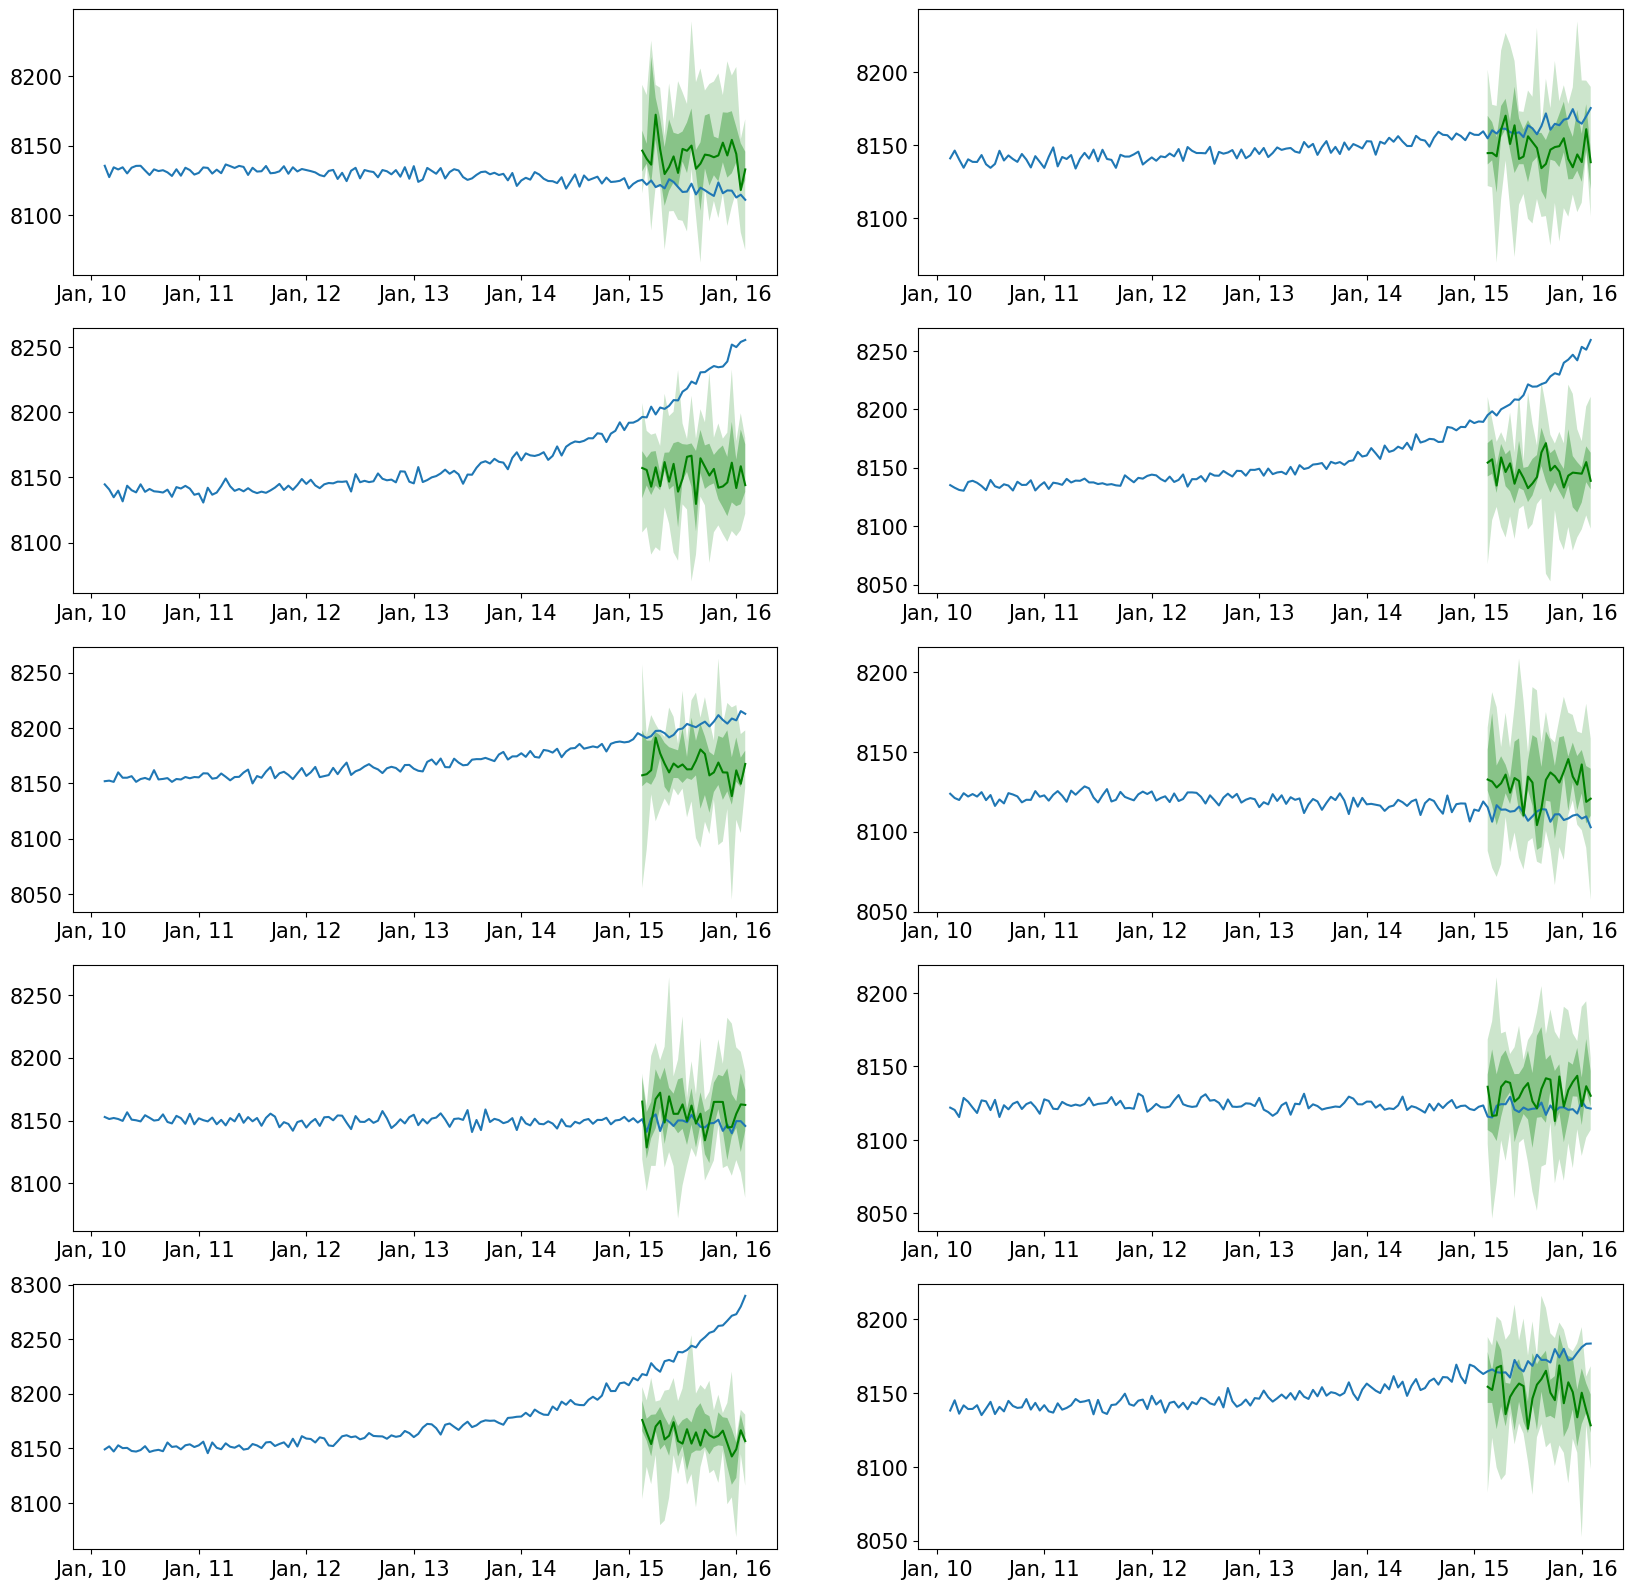

In [59]:
plt.figure(figsize=(20, 20))
date_formater = mdates.DateFormatter('%b, %d')
plt.rcParams.update({'font.size': 15})

# Iterate through the first 9 series, and plot the predicted samples
for idx, (forecast, ts) in islice(enumerate(zip(forecasts, tss)), 10):
    ax = plt.subplot(5, 2, idx+1)

    plt.plot(ts[-6 * prediction_length:].to_timestamp(), label="target", )
    forecast.plot(color='g')
    plt.xticks()
    ax.xaxis.set_major_formatter(date_formater)

In [56]:
evaluator = Evaluator()
agg_metrics, ts_metrics = evaluator(iter(tss), iter(forecasts))

Running evaluation: 100it [00:00, 1222.93it/s]
/Users/junbo/miniconda3/envs/lag_llama/lib/python3.12/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
/Users/junbo/miniconda3/envs/lag_llama/lib/python3.12/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
/Users/junbo/miniconda3/envs/lag_llama/lib/python3.12/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
/Users/junbo/miniconda3/envs/lag_llama/lib/python3.12/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up seria

In [57]:
print("CRPS:", agg_metrics['mean_wQuantileLoss']) 
# CRPS: 0.003096954624169306 (context length = 32)
# CRPS: 0.0030780953773832734 (context length = 128)
# so context length affects little :(

CRPS: 0.0030780953773832734


#### Feedback from Daniel K. (23. May)

On Lag-Llama model:
- look into so-called 'temperature parameter' in LLMs and see if Lag-Llama has sth similar (is Student-T distribution related to this?) Increase in this 'temperature parameter' results in more uniform output etc. **a parametric distribution head decides the forecast distribution for time t+1**
- What are the 2.4 M params being fine-tuned? PyTorch functionality
- How to improve fine-tuned results? **better train/test split, k-fold cross- validation**

On zero-shot forecasting results
- Why are the 50%/90% uncertainty bounds almost uniform throughout the prediction horizon? Intuitively they should be narrow at first and grow wider in time due to greedy autoregressive prediction. **according to Daniel H., **
- Why is there sudden jump in value at the first predicted timestamp?
- Try incorperate zero-shot and fine-tuned plots into one for better comparison.

On input datasets:
- Change timestamps from Hours to Days, Minutes, etc. and experiment.
- Dealing with non-uniform trajectory length while not losing data: how to sample training datasets and smartly deal with NaN, 

Approach 1: leaving NaN values as they are, 
Approach 2: align at the failure at the end and truncate the data at the beginning: 

**For both approaches, CPRS still 0.003, equally bad, cannot capture trend.**

#### To-do's from Saturday 25. May
- Revisit train/val/test splitting of GluonTS library, understand how it works and see if I've been doing it wrong
- Deep transfer learning literature, summarize it
- Research on other fine-tuning techniques for Lag-Llama, also what are the 2.4 Mio params being fine-tuned at all?
- Where are the codes for Distribution head (studentT)?

How is the negative log likelihood defined?